In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import fill
import numpy as np
import pandas as pd
import scanpy.external as sce
import scanpy as sc
import anndata as an
from scipy.spatial.distance import cdist
import scvelo as scv
# import gget
import re
# import rapids_singlecell as rsc
from scipy.stats import linregress
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# import cellrank as cr

sc.settings.verbosity = 3 

print(scv.__version__)

0.3.3


In [2]:
import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('py.warnings').setLevel(logging.ERROR)

# Load expression

In [3]:
%%time
fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/new_processed/new_scvelo.h5ad"
# fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/new_processed/new_pseudotime.h5ad"
adata = sc.read_h5ad(fpath)
# adata.X = adata.layers['log_norm'].copy()
adata

CPU times: user 449 ms, sys: 8.33 s, total: 8.78 s
Wall time: 29min 16s


AnnData object with n_obs × n_vars = 15317 × 23434
    obs: 'batch', 'barcoded_phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'velocity_pseudotime', 'G1_velocity_pseudotime', 'G2M_velocity_pseudotime', 'mean_velocity_pseudotime'
    var: 'gene_id', 'gene_type', 

In [7]:
# new cluster names
new_grouping = {  
    'R2': ['C1'],
    'R1': ['C2'],
    'C5': ['C3'],
    'C4': ['C4'],
    'R3': ['C5'],
}

# Invert the mapping: from old -> new
reverse_map = {old: new for new, olds in new_grouping.items() for old in olds}

adata.obs['cluster_str'] = adata.obs['cluster_str'].astype(str)

# create new grouping
adata.obs['cluster'] = adata.obs['cluster_str'].map(reverse_map)
adata.obs['cluster'] = adata.obs['cluster'].astype('category')

adata.obs['cluster_str'] = adata.obs['cluster_str'].astype('category')

print(adata.obs['cluster'].value_counts())

# define custom palette
clusters = adata.obs['cluster'].cat.categories
print(clusters)

cluster_colors = {
    'R1': '#02A679',
    'R2': '#D55E00',
    'R3': '#F9CF86',
    'C4': '#FFA9E6',
    'C5': '#5C5D9E',
}

adata.uns['cluster_colors'] = [cluster_colors[c] for c in clusters]

cluster
C4    4612
R2    4343
C5    3852
R1    1986
R3     524
Name: count, dtype: int64
Index(['C4', 'C5', 'R1', 'R2', 'R3'], dtype='object')


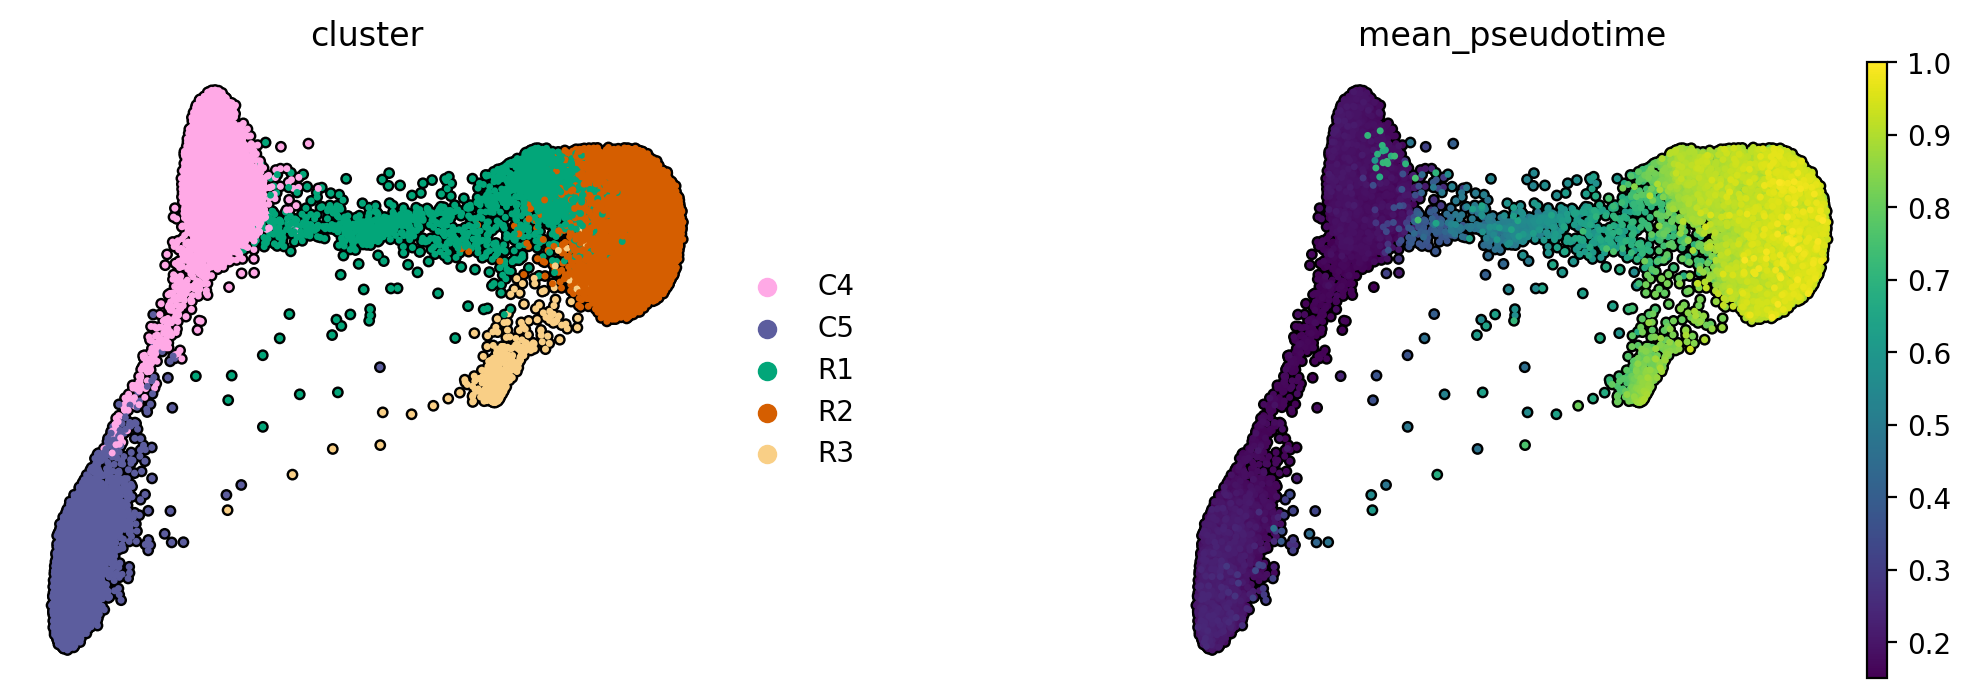

In [8]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.draw_graph(
    adata, 
    color=['cluster', 'mean_pseudotime'],
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    wspace=0.5,
)

# Load velocity

In [10]:
%%time

fpaths = {
    "hsc" : "/scratch/indikar_root/indikar1/shared_data/hsc_velocyto/merged_NKUVW.loom",
    "fib" : "/scratch/indikar_root/indikar1/shared_data/fib_velocyto/merged_PW6SH.loom",
}

ldatas = []
for key, fpath in fpaths.items():
    print(f"Working {key}...")

    ldata = sc.read_loom(fpath)
    ldata.var_names_make_unique()

    # set the cell-ids back to barcodes
    ldata.obs['velocyto_cell_id'] = ldata.obs_names.copy()
    ldata.obs['cell_id'] = ldata.obs['velocyto_cell_id'].apply(lambda x: x.split(":")[1][:-1] + "-1")
    
    if key == 'fib':
        ldata.obs['cell_id'] = ldata.obs['cell_id'] + '_fib'
    else:
        ldata.obs['cell_id'] = ldata.obs['cell_id'] + '_hsc'
        
    ldata.obs_names = ldata.obs['cell_id'].values

    # Print initial cell counts
    print(f"\tInitial cell count in ldata: {ldata.shape[0]}")
    print(f"\tInitial cell count in adata: {adata.shape[0]}")
    
    # IDs not retained in ldata
    removed_from_ldata = ldata.obs.index[~ldata.obs.index.isin(adata.obs_names)].tolist()
    
    # IDs not retained in adata
    removed_from_adata = adata.obs.index[~adata.obs.index.isin(ldata.obs_names)].tolist()
    
    # Filter ldata to keep only cells present in adata
    initial_ldata_count = ldata.shape[0]
    ldata = ldata[ldata.obs.index.isin(adata.obs_names), :].copy()
    print(f"\tFiltered ldata: {ldata.shape[0]} cells kept, {initial_ldata_count - ldata.shape[0]} cells removed")

    ldatas.append(ldata)

    
ldata = an.concat(ldatas)   
ldata

Working hsc...
	Initial cell count in ldata: 11933
	Initial cell count in adata: 15317
	Filtered ldata: 8357 cells kept, 3576 cells removed
Working fib...
	Initial cell count in ldata: 8963
	Initial cell count in adata: 15317
	Filtered ldata: 6960 cells kept, 2003 cells removed
CPU times: user 50.2 s, sys: 13.9 s, total: 1min 4s
Wall time: 1min 4s


AnnData object with n_obs × n_vars = 15317 × 38606
    obs: 'velocyto_cell_id', 'cell_id'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

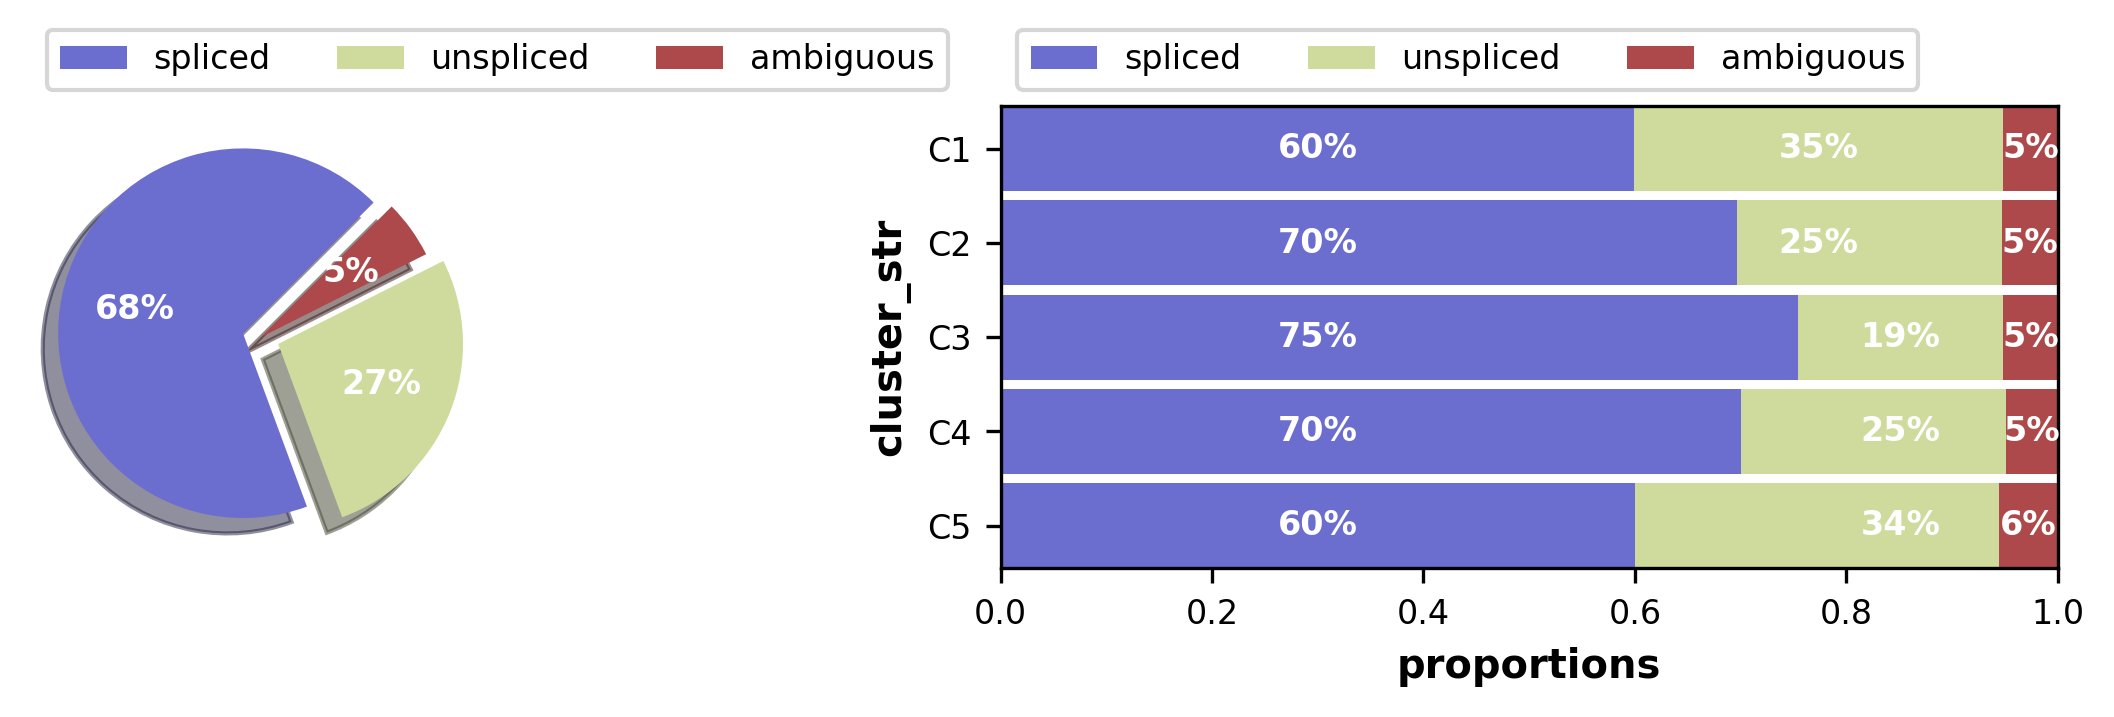

AnnData object with n_obs × n_vars = 15317 × 23434
    obs: 'batch', 'barcoded_phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'gene_id', 'gene_type', 'Chromosome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total

In [11]:
adata = scv.utils.merge(adata, ldata)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 5

scv.pl.proportions(adata, groupby='cluster_str', dpi=300)

adata

In [12]:
%%time
sc.pp.neighbors(adata, n_neighbors=150, use_rep='X_pca_harmony')
scv.pp.moments(adata, use_rep='X_pca_harmony')

scv.tl.recover_dynamics(adata, n_jobs=8) 

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:50)
Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:15) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 8/40 cores)
or disable the progress bar using `show_progress_bar=False`.


/nfs/turbo/umms-indikar/Jillian/conda-envs/scvelo/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=188147) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


    finished (0:13:09) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
CPU times: user 2min 42s, sys: 46.8 s, total: 3min 28s
Wall time: 14min 18s


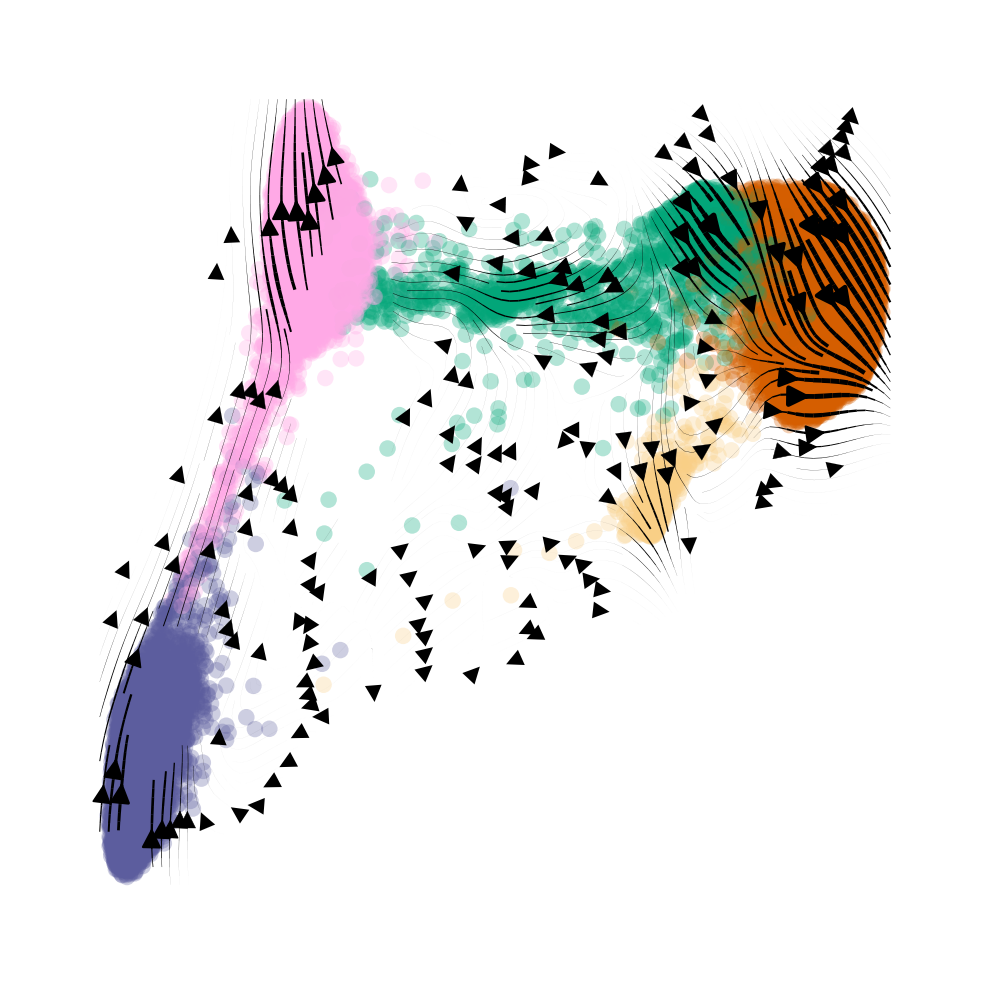

CPU times: user 2.61 s, sys: 16.3 ms, total: 2.63 s
Wall time: 2.65 s


In [12]:
%%time
# scv.tl.velocity(adata, mode='dynamical')
# scv.tl.velocity(adata)

# scv.tl.velocity_graph(
#     adata, 
#     n_jobs=8,
#     basis='X_pca_harmony',
#     n_neighbors=150,
# )

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

scv.pl.velocity_embedding_stream(
    adata, 
    density=(3, 3),
    basis='X_draw_graph_fa',
    color='cluster',
    smooth=True,
    title="",
    legend_loc='none',
    # legend_loc='right_margin',
    linewidth=0.75,
    arrow_size=1,
    add_margin=0.1,
)

G1: root_id='CGTAAAGGTTCGTGGC-1_fib' root_key=11683
G2M: root_id='AGAGAATCATTCGCTA-1_fib' root_key=9410


/nfs/turbo/umms-indikar/Jillian/conda-envs/scvelo/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/nfs/turbo/umms-indikar/Jillian/conda-envs/scvelo/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/nfs/turbo/umms-indikar/Jillian/conda-envs/scvelo/lib/python3.13/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/nfs/turbo/um

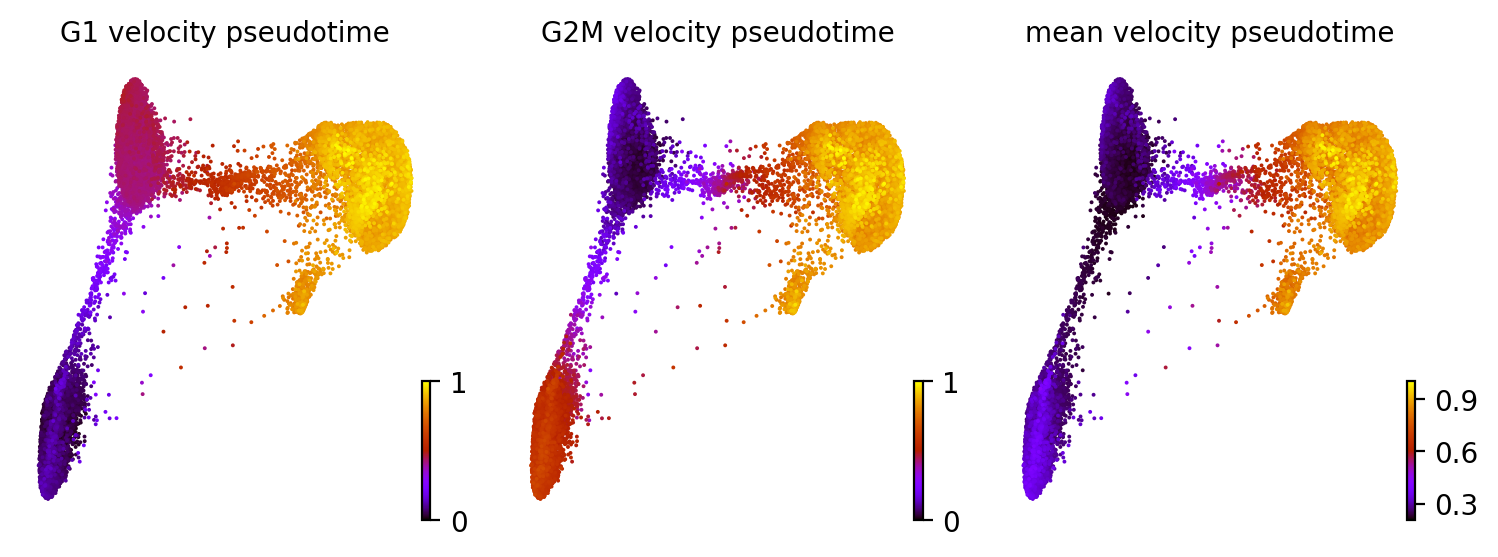

CPU times: user 23.3 s, sys: 25.4 s, total: 48.7 s
Wall time: 42.5 s


In [16]:
%%time
def find_closest_cell(adata, obs_key='barcoded_phase', value='G1', obsm_key='X_pca'):
    """
    Find the cell closest to a median vector in PCA space.

    Parameters:
        adata (AnnData): Annotated data matrix.
        obs_key (str): Key in adata.obs indicating group
        value (str): The value for aggregation 
        obsm_key (str): Key in adata.obsm for PCA or other embedding.

    Returns:
        tuple: (cell_id (str), index (int)) of the closest G1 cell in adata.obs_names
    """
    mask = adata.obs[obs_key] == value
    emb = adata.obsm[obsm_key][mask]

    median_vec = np.median(emb, axis=0)
    dists = cdist(emb, median_vec.reshape(1, -1)).flatten()
    closest_idx = np.argmin(dists)

    cell_id = adata.obs_names[mask][closest_idx]
    cell_index = np.where(adata.obs_names == cell_id)[0][0]

    return cell_id, cell_index

# loop through initial state
for phase, cluster in zip(['G1', 'G2M'], ['C3', 'C4']):
    root_id, root_key = find_closest_cell(
        adata,
        obs_key='cluster_str',
        value=cluster,
    )

    print(f"{phase}: {root_id=} {root_key=}")

    scv.tl.velocity_pseudotime(adata, root_key=root_key)
    adata.obs[f'{phase}_velocity_pseudotime'] = adata.obs['velocity_pseudotime']


adata.obs['mean_velocity_pseudotime'] = adata.obs[['G1_velocity_pseudotime', 'G2M_velocity_pseudotime']].mean(axis=1)


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

scv.pl.scatter(
    adata, 
    color=['G1_velocity_pseudotime', 'G2M_velocity_pseudotime', 'mean_velocity_pseudotime'],
    basis='X_draw_graph_fa',
    cmap='gnuplot',
)

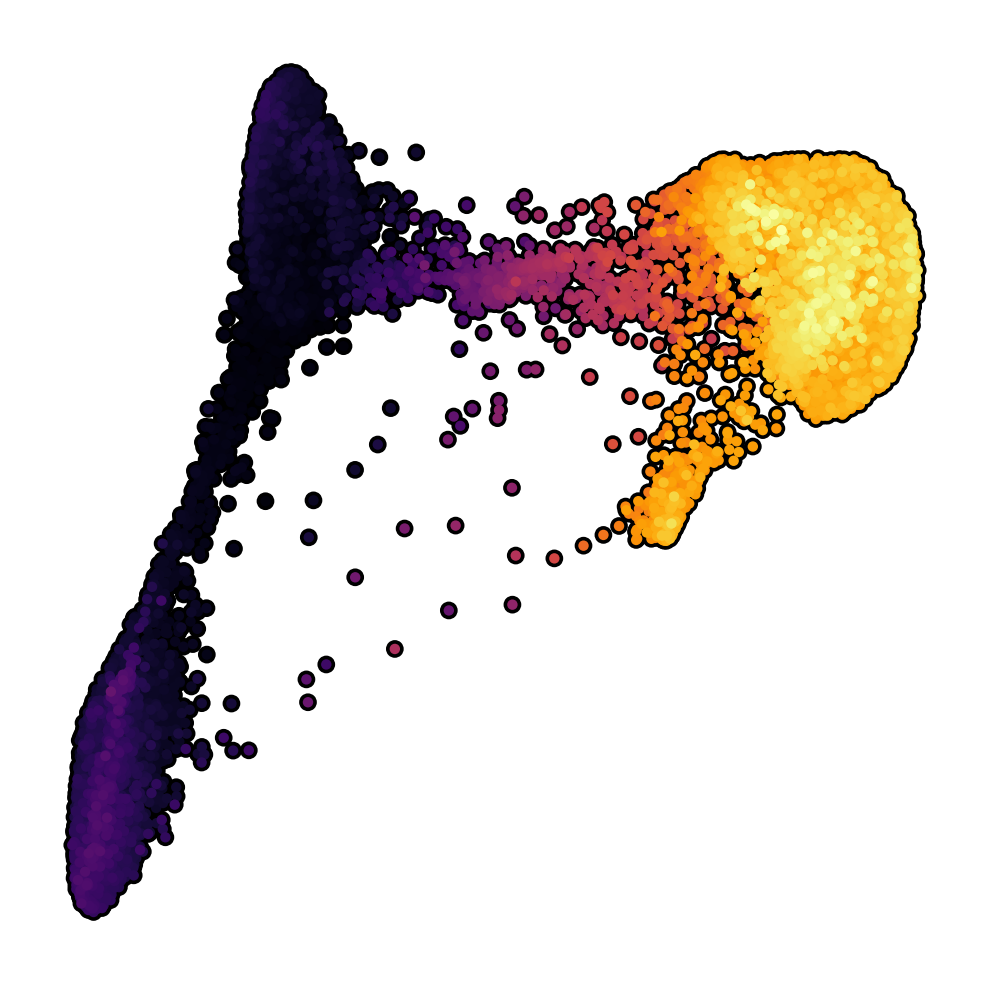

In [5]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.draw_graph(
    adata, 
    color=['mean_velocity_pseudotime'],
    size=25,
    cmap='inferno',
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    outline_color=('k', 'k'),
    title="",
    frameon=False,
    colorbar_loc=None,
    wspace=0.5,
)

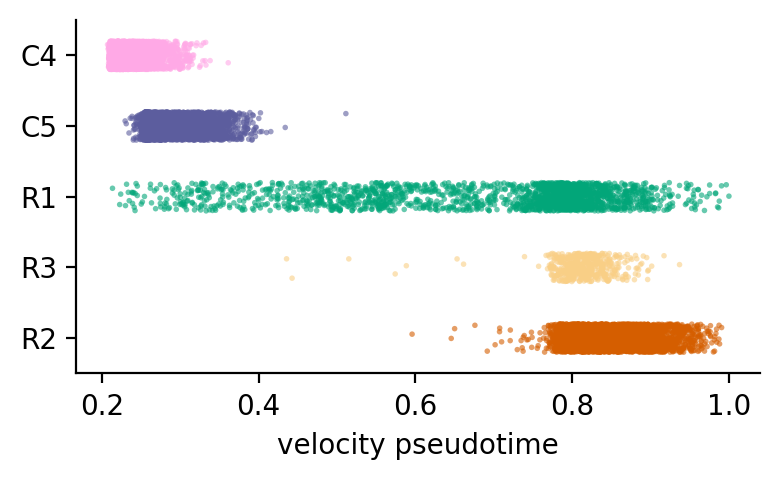

In [15]:
df = pd.DataFrame({
        'pseudotime' : adata.obs['mean_velocity_pseudotime'].values,
        'cell_id': adata.obs_names,
        'cluster' : adata.obs['cluster'].values,
    })

df = df.sort_values(by='pseudotime', ascending=True)

df.head()

palette = adata.uns['cluster_colors']

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2.5

sns.stripplot(
    data=df,
    x='pseudotime',
    y='cluster',
    hue='cluster',
    order=['C4', 'C5', 'R1', 'R3', 'R2'],
    size=2,
    jitter=0.2,
    alpha=0.6,
    linewidth=0,
    palette=palette,
)

plt.xlabel("velocity pseudotime")
plt.ylabel("")

sns.despine()
plt.tight_layout()
plt.show()

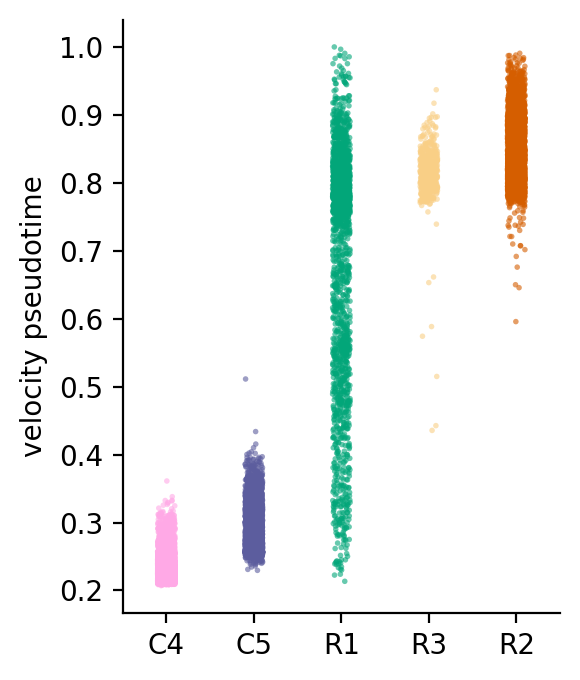

In [20]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3.5

sns.stripplot(
    data=df,
    x='cluster',
    y='pseudotime',
    hue='cluster',
    order=['C4', 'C5', 'R1', 'R3', 'R2'],
    size=2,
    # jitter=0.2,
    alpha=0.6,
    linewidth=0,
    palette=palette,
)

plt.ylabel("velocity pseudotime")
plt.xlabel("")

sns.despine()
plt.tight_layout()
plt.show()

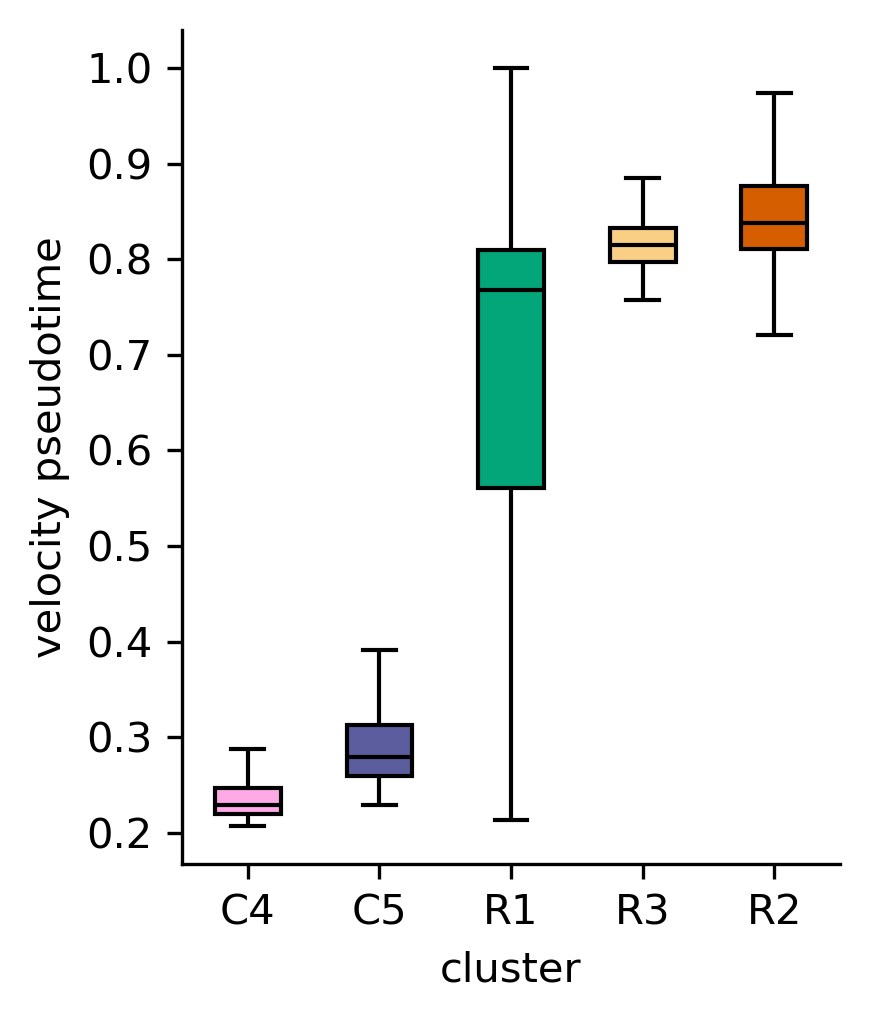

In [30]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3.5

sns.boxplot(
    data=df,
    x='cluster',
    y='pseudotime',
    hue='cluster',
    order=['C4', 'C5', 'R1', 'R3', 'R2'],
    width=0.5,
    linecolor='k',
    showfliers=False,
    palette=palette,
    saturation=1,
)

plt.ylabel("velocity pseudotime")
plt.xlabel("cluster")

sns.despine()
plt.tight_layout()
plt.show()

In [6]:
adata

AnnData object with n_obs × n_vars = 15317 × 23434
    obs: 'batch', 'barcoded_phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'velocity_pseudotime', 'G1_velocity_pseudotime', 'G2M_velocity_pseudotime', 'mean_velocity_pseudotime'
    var: 'gene_id', 'gene_type', 

In [4]:
# adata.uns['cluster_str_colors_old'] = adata.uns['cluster_str_colors'].copy()

# adata.uns['cluster_str_colors'] = ['#FCAE91', '#FB6A4A', '#CB181D', '#808080', '#808080']

# adata.uns['cluster_str_colors']

['#FCAE91', '#FB6A4A', '#CB181D', '#808080', '#808080']

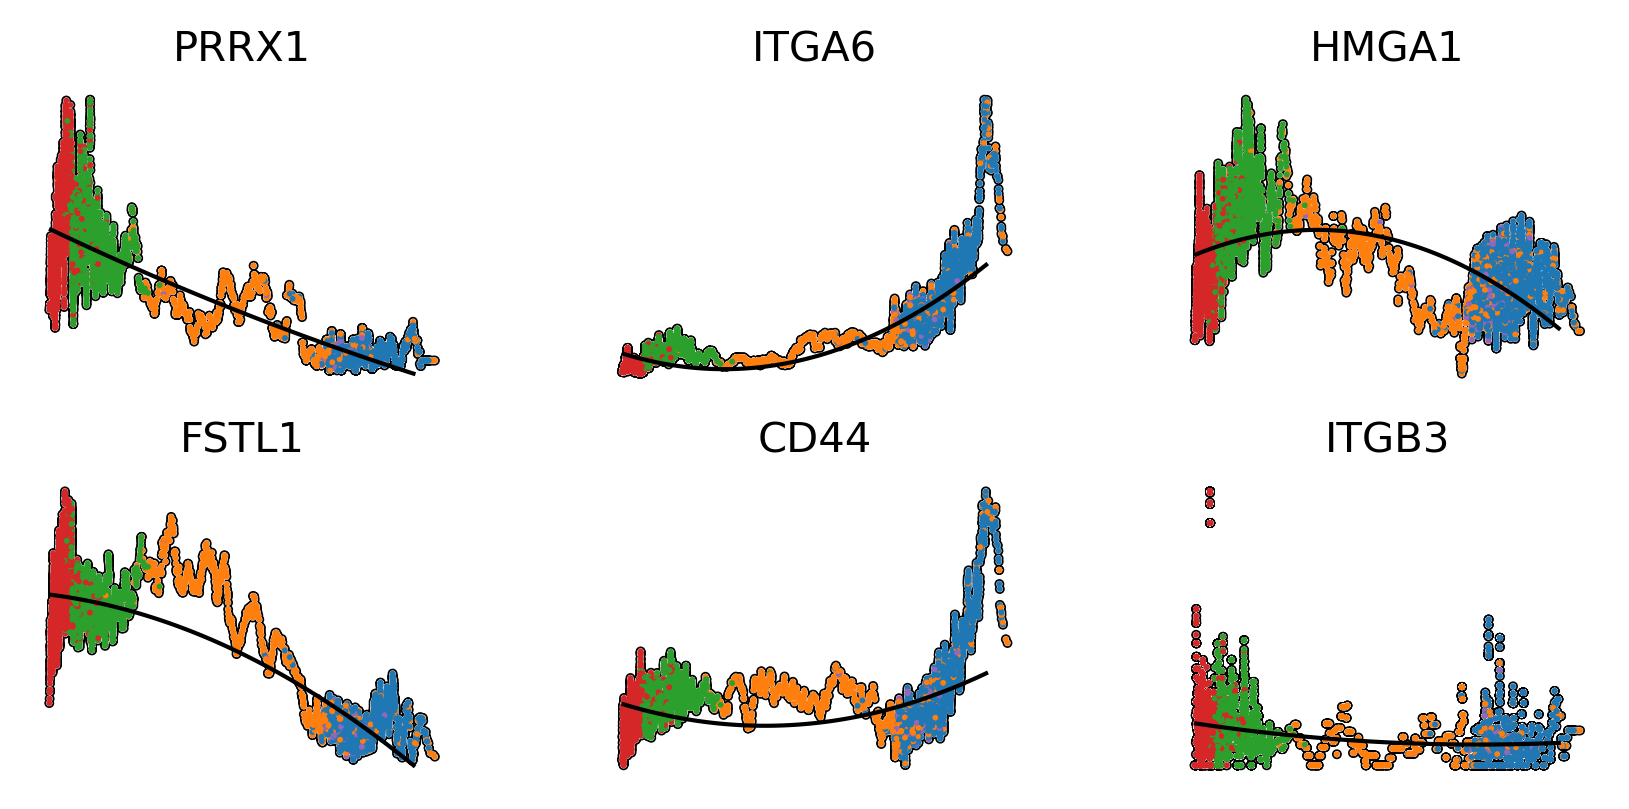

In [43]:
# var_names = ['CD34', 'ACE', 'ITGA6', 'HMGB1', 'CSNK2B', 'MYLK']

# var_names = ['CD34', 'ACE', 'ITGA6', 'HMGB1', 'CSNK2B', 'MYLK', 'LMO2', 'SCL', 'ETV2', 'RUNX1', 'GATA2', 'GFI1', 'SPI1', 'CD44',
            #  'GFI1B', 'TWIST1', 'TWIST2', 'MYB', 'SNAI1', 'SNAI2', 'EZH1', 'EZH2', 'SMAD3', 'RBFOX2',
            # ]

var_names = [
    
#     'PRRX1', 'FSTL1', 'COL1A2',
    
#     # 'DCN', 'PRRX1', 'COL1A2', 'SRF', 'FBNL2', 'LUM', 'FSTL1',
#     'ITGA6', 'ETV2', 'CD44', # EHT-related
    # 'RBFOX2', 'SMAD3', 'HMGB1', # splicing, stemness maintenance, chromatin remodeling
    
    # 'CD34', 'RUNX1', 'TGFB1', 'HMGA1', 'HMGA2', 'IGF2BP2', 'ITGB3', 'SCA1', 'TGFBI', 'ITGAM', 'PROCR',
    
    'PRRX1', 'ITGA6', 'HMGA1',
    'FSTL1', 'CD44', 'ITGB3',
]
    


var_names = [g for g in var_names if g in adata.var_names]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2.25, 1.5

scv.pl.scatter(
    adata, 
    x='mean_velocity_pseudotime', 
    y=var_names, 
    add_polyfit=True,
    ncols=3,
    normalize_data=True,
    add_outline=True,
    frameon=False,
    n_convolve=50,
    smooth=True,
    color='cluster_str',
    wspace=0.35,
)

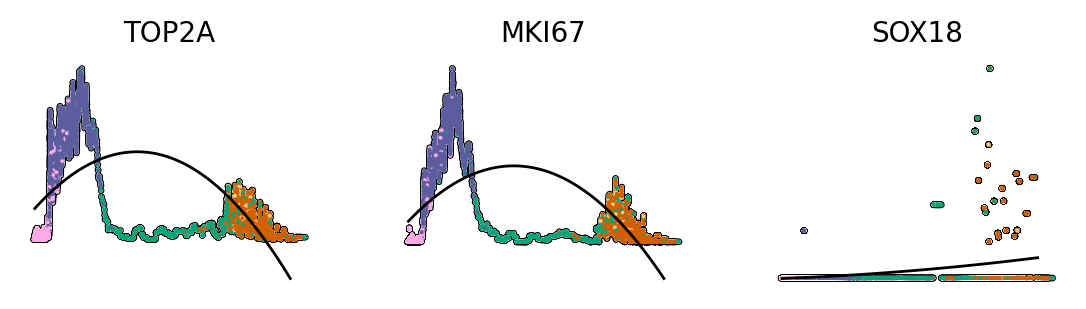

In [90]:
var_names = [
    # 'CD34', 'ACE', 'ITGA6',
    # 'CD44', 
    # 'PCNA', 'PLK1',
    
    # 'MKI67', 'PRRX1', 'ACE', 'CD34', #'MEIS1', #'MSI2',
    # 'TOP2A', 'FSTL1', 'CD44', 'ITGA6', #'PROCR', 
    
    # 'RUNX1', 'MSI2', 'MEIS1', 'PROCR',

    
    # 'ACE', 'CD34', 'PRRX1', 'MKI67',
    # 'CD44', 'ITGA6', 'FSTL1', 'TOP2A',
    # 'RUNX1', 'MSI2', 'MEIS1', 'PROCR',
    
    # 'ACE', 'CD34', 'PRRX1', 
    # 'CD44', 'ITGA6', 'FSTL1',
    # 'RUNX1', 'MSI2', 'DCN',#'MEIS1', 'PROCR',
    
    'TOP2A', 'MKI67', 'SOX18',
    
    # 'MEIS1', 'HOPX', 'MECOM', 'BMI1', 'MLLT3', 'PROM1', 'PROCR', 'RUNX1', 'MSI2', 'SPI1', 'SOX17', 'CD164', 'GATA1', 
    # 'CD164', 'HLF', 'IGF2BP1', 'HES1', 'LMO2', 'ERG', 'ESAM',
    
]

var_names = [g for g in var_names if g in adata.var_names]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 2.25, 1.5

scv.pl.scatter(
    adata, 
    x='mean_velocity_pseudotime', 
    y=var_names, 
    add_polyfit=True,
    ncols=3,
    normalize_data=True,
    add_outline=True,
    frameon=False,
    n_convolve=50,
    smooth=True,
    color='cluster',
    wspace=0.25,
    hspace=0.5,
    # xlabel="velocity pseudotime",
    # ylabel="spliced counts",
    # fontsize=9,
)

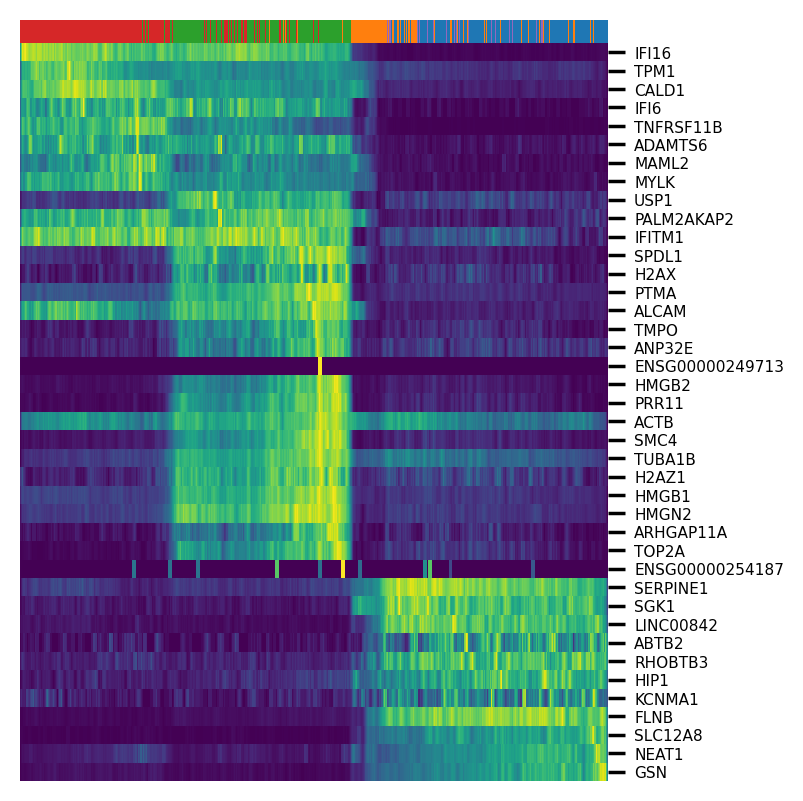

In [58]:
n_genes = 40

df = adata.var.copy()

top_n = df.nlargest(n_genes, 'fit_likelihood')

plt.rcParams['figure.dpi'] = 200

scv.pl.heatmap(
    adata, 
    var_names=top_n.head(n_genes).index, 
    sortby='mean_velocity_pseudotime', 
    col_color='cluster_str', 
    figsize=(4, 4),
    yticklabels=True,
    n_convolve=100,
    layer='spliced',
    font_scale=0.5,
    standard_scale=0,
)

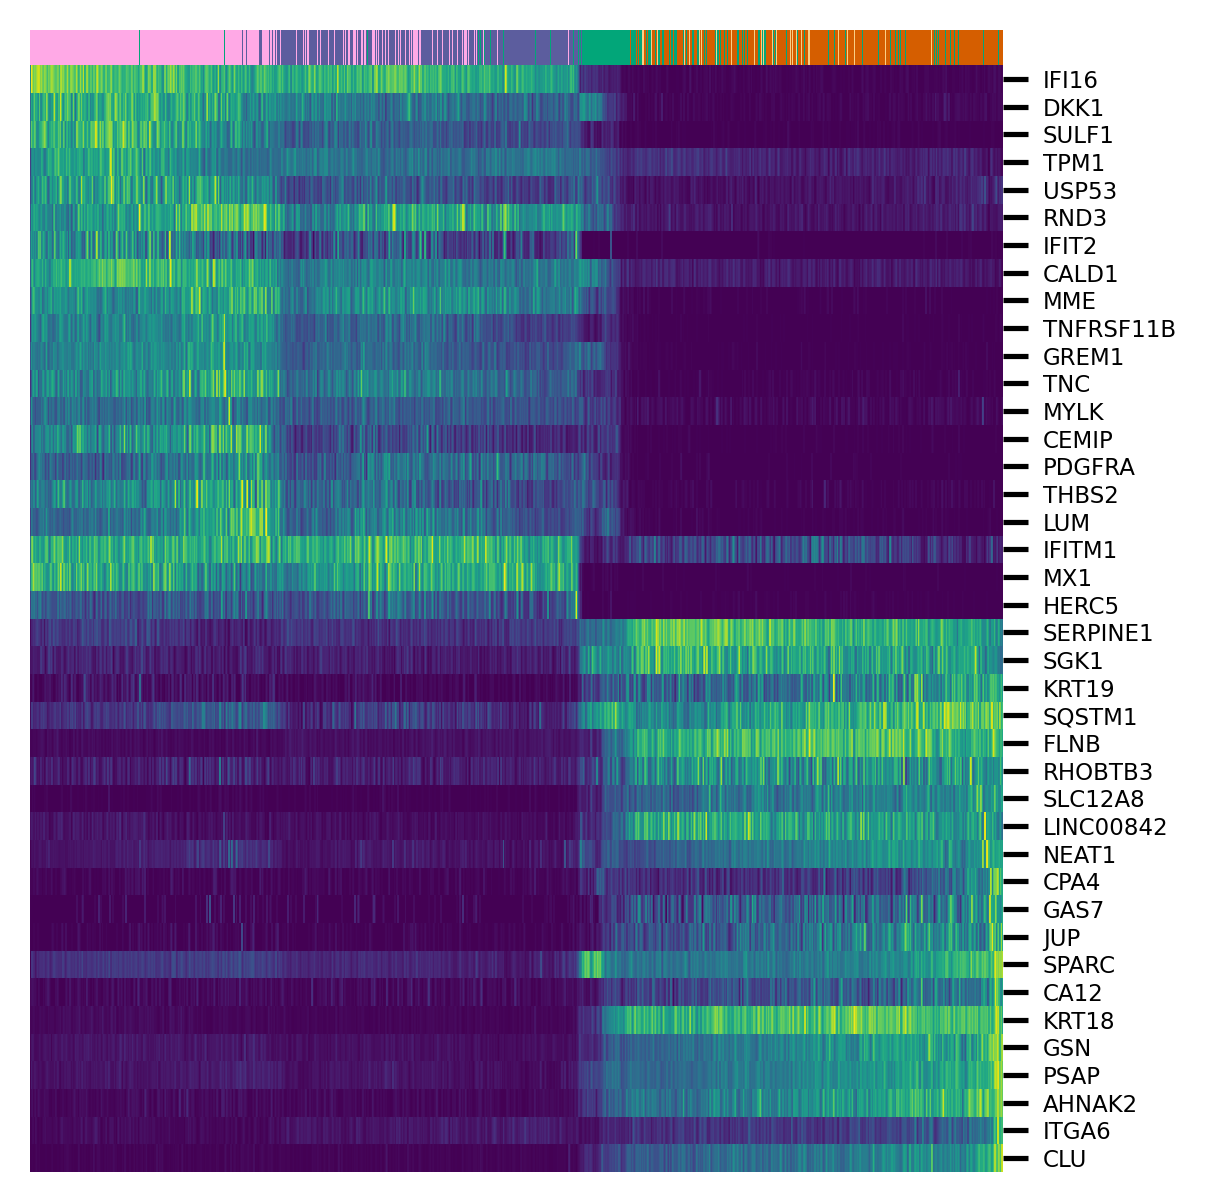

In [32]:
mask = (
    (adata.var['velocity_genes']) &
    (adata.var['fit_r2'] > 0.5) &
    (adata.var['velocity_r2'] > 0.3)
)

pt = adata.obs['mean_velocity_pseudotime']
X = adata[:, mask].layers['spliced'].toarray()

cors = np.array([
    spearmanr(X[:, i], pt)[0]
    for i in range(X.shape[1])
])

gene_names = adata.var_names[mask]
cors = pd.Series(cors, index=gene_names)

top_pos = cors.sort_values(ascending=False).head(20).index
top_neg = cors.sort_values().head(20).index

selected_genes = list(top_pos) + list(top_neg)

scv.pl.heatmap(
    adata, 
    var_names=selected_genes, 
    sortby='mean_velocity_pseudotime', 
    col_color='cluster', 
    figsize=(4, 4),
    yticklabels=True,
    # n_convolve=100,
    layer='spliced',
    font_scale=0.5,
    # standard_scale=0,
)

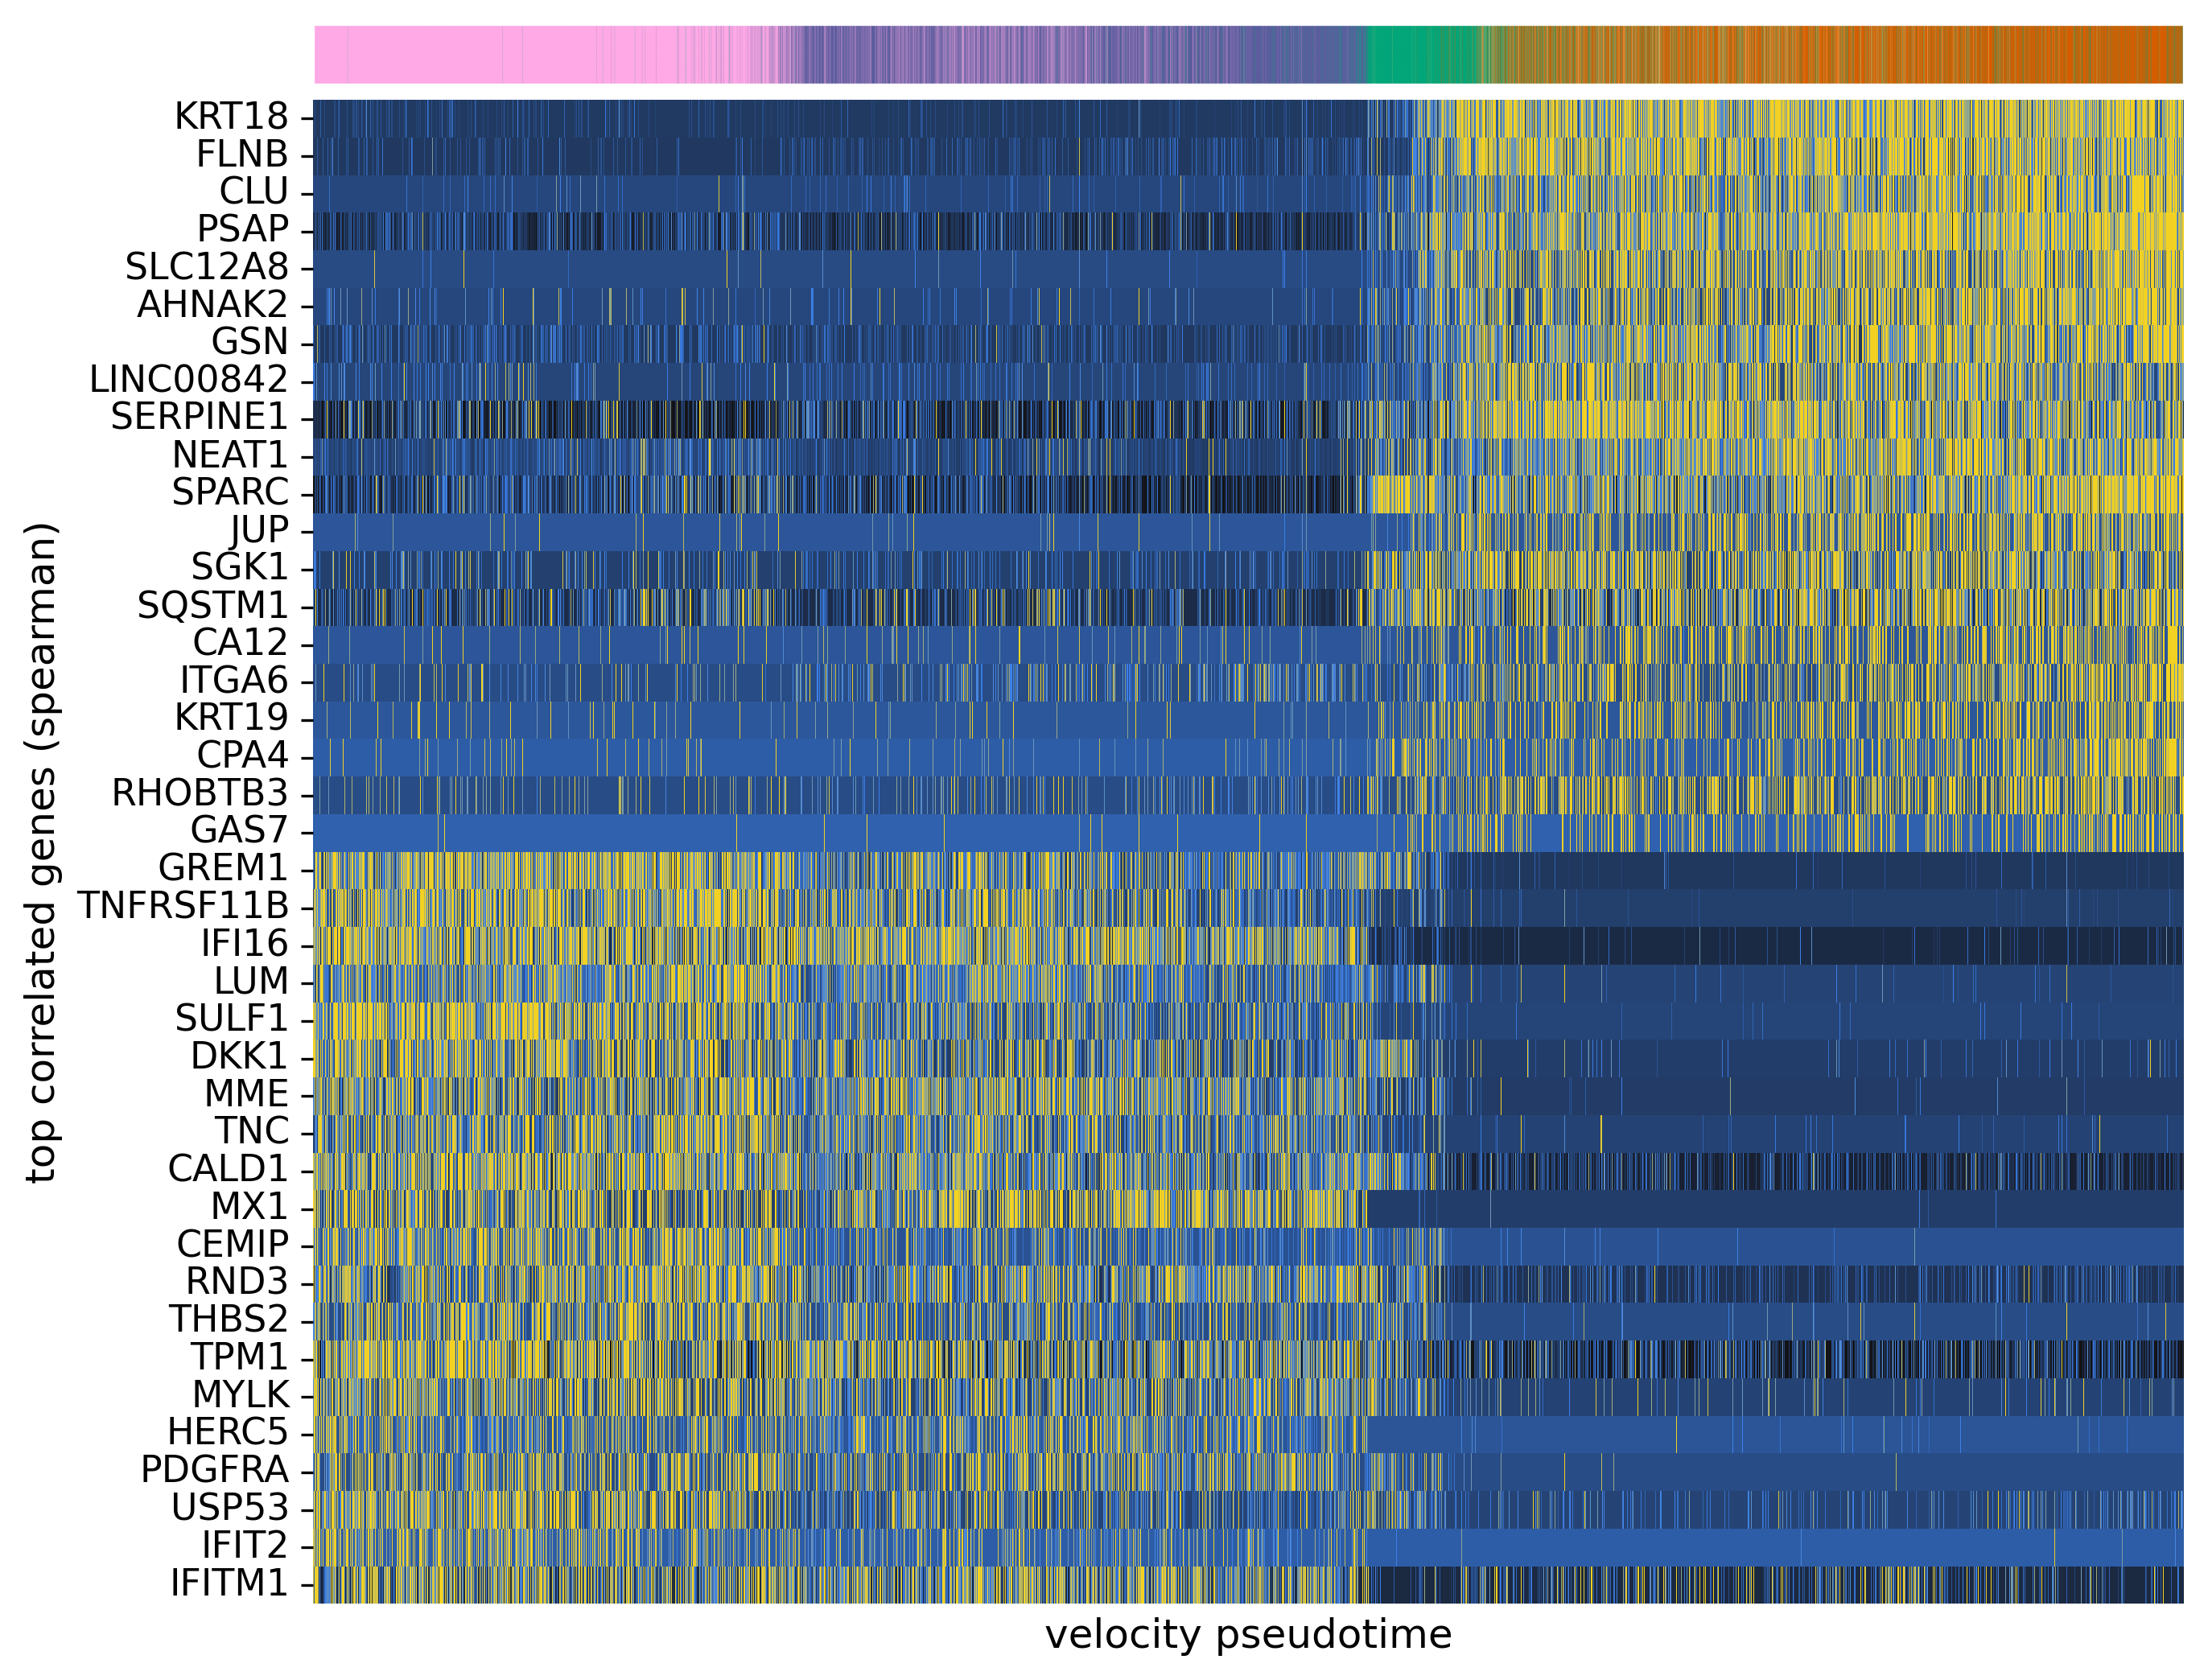

In [43]:
from matplotlib import gridspec
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap

low = '#131317' # dark
mid = '#3B80EB' # blue
high = '#F2D123' # yellow

custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap",
    [(0.0, low), (0.15, low), (0.5, mid), (0.85, high), (1.0, high)]
)

cell_order = adata.obs.sort_values("mean_velocity_pseudotime").index
n_cells = len(cell_order)

adata.X = adata.layers['spliced'].copy()

expr = adata[cell_order, selected_genes].X
if not isinstance(expr, np.ndarray):
    expr = expr.toarray()

# z-score expression
expr_z = zscore(expr, axis=0)

# get bar for cluster order
clusters = adata.obs.loc[cell_order, 'cluster']

# mapping: category → color
cluster_colors = dict(zip(
    adata.obs['cluster'].cat.categories,
    adata.uns['cluster_colors']
))

# convert cluster labels to colors for each cell in order
col_colors = clusters.map(cluster_colors).to_numpy()
rgba_colors = np.array([to_rgba(c) for c in col_colors])


fig = plt.figure(figsize=(10, 8.5), dpi=300)

gs = gridspec.GridSpec(
    2, 1, 
    height_ratios=[0.4, 10],   # small top bar, big heatmap
    hspace=0.02                 # small spacing
)

# --- Top colorbar axis (tiny horizontal strip) ---
ax_color = fig.add_subplot(gs[0])

ax_color.imshow(rgba_colors[np.newaxis, :, :], aspect='auto')
ax_color.set_xlim(0, n_cells)
ax_color.set_xticks([])
ax_color.set_yticks([])
for spine in ax_color.spines.values():
    spine.set_edgecolor('white')

ax_heat = fig.add_subplot(gs[1])

sns.heatmap(
    expr_z.T,
    cmap=custom_cmap,
    xticklabels=False,
    yticklabels=selected_genes,
    vmin=-1.5,
    vmax=1.5,
    cbar=False,
    ax=ax_heat,
)
ax_heat.set_yticklabels(ax_heat.get_yticklabels(), fontsize=11)
ax_heat.set_xlabel("velocity pseudotime", fontsize=12)
ax_heat.set_ylabel("top correlated genes (spearman)", fontsize=12)

plt.tight_layout()
plt.show()

In [87]:
top_neg = cors.sort_values().head(50).index
top_neg

Index(['GREM1', 'TNFRSF11B', 'IFI16', 'LUM', 'SULF1', 'DKK1', 'MME', 'TNC',
       'CALD1', 'MX1', 'CEMIP', 'RND3', 'THBS2', 'TPM1', 'MYLK', 'HERC5',
       'PDGFRA', 'USP53', 'IFIT2', 'IFITM1', 'PTN', 'EFEMP1', 'PALM2AKAP2',
       'DCN', 'MAML2', 'LPAR1', 'SEMA5A', 'COL8A1', 'PRRX1', 'IFI6', 'NRP1',
       'WNT5A', 'ADAMTS6', 'MMP3', 'FBN2', 'ENPP2', 'MMP1', 'EPSTI1', 'TPM2',
       'ALDH1A1', 'RUNX1T1', 'KIF26B', 'PTMA', 'EXT1', 'REV3L', 'DSP', 'FN1',
       'LIMCH1', 'SEMA3C', 'BICC1'],
      dtype='object')

In [89]:
top_pos = cors.sort_values(ascending=False).head(100).index
top_pos

Index(['KRT18', 'FLNB', 'CLU', 'PSAP', 'SLC12A8', 'AHNAK2', 'GSN', 'LINC00842',
       'SERPINE1', 'NEAT1', 'SPARC', 'JUP', 'SGK1', 'SQSTM1', 'CA12', 'ITGA6',
       'KRT19', 'CPA4', 'RHOBTB3', 'GAS7', 'SCARA5', 'DPYSL3', 'HIP1', 'GFPT2',
       'LINC00839', 'NDRG4', 'UBASH3B', 'NEBL', 'PLAT', 'KANK4', 'IRAK3',
       'MATN2', 'CCN4', 'HEG1', 'MAPT', 'DAAM1', 'PLXNA4', 'IGFL2-AS1', 'ANO1',
       'MAGI1', 'MAP2', 'CHAT', 'UNC5C', 'CTPS1', 'ODAPH', 'MYPN', 'ANKRD1',
       'PKP2', 'LYPD6B', 'AURKA', 'CIT', 'PRC1', 'CENPE', 'CDC25C', 'HJURP',
       'KIF18B', 'ADGRD1', 'GAS2L3', 'DLGAP5', 'ASPM', 'ANP32E', 'CDCA8',
       'RRM2', 'PBK', 'BUB1B', 'KNL1', 'KIF18A', 'KIF15', 'KIF14', 'NUSAP1',
       'ARHGAP11A', 'CCNA2', 'RFC3', 'MKI67', 'CDCA2', 'PCLAF', 'NSD2',
       'H2AZ1', 'H2AX', 'TRIP13', 'DIAPH3', 'PLCB4', 'DBF4', 'TOP2A', 'FANCI',
       'TMPO', 'KIF23', 'SGO2', 'KIFC1', 'CLSPN', 'TNFSF10', 'GTSE1', 'BUB3',
       'CENPF', 'KCNQ5', 'SLC38A11', 'GBP4', 'CEP55', 'PRR11', 'SMC4'],
 

In [92]:
cors.head()

ACKR4     -0.208331
ACTG1     -0.129107
ADAMTS6   -0.359917
ADGRD1    -0.006264
AFF3      -0.209990
dtype: float64

In [45]:
import gget

# enrichr

In [91]:
n_genes = 50

top_pos = cors.sort_values(ascending=False).head(n_genes).index
top_neg = cors.sort_values().head(n_genes).index

# pd.set_option('display.max_colwidth', None)

# database = 'celltypes'
database = "GO_Biological_Process_2025"
# database="KEGG_2021_Human"
# database='MSigDB_Hallmark_2020' 
# database="Reactome_Pathways_2024"
# database = "CellMarker_2024"
# database='Tabula_Sapiens'


edf_pos = gget.enrichr(top_pos, database=database, save=False)
display(edf_pos[['path_name', 'overlapping_genes', 'adj_p_val']].head(15))
print("=" * 100 + "\n")

edf_neg = gget.enrichr(top_neg, database=database, save=False)
display(edf_neg[['path_name', 'overlapping_genes', 'adj_p_val']].head(15))
print("=" * 100 + "\n")

18:16:39 - INFO - Performing Enrichr analysis using database GO_Biological_Process_2025.


path_name  \
0                                 Regulation of Cellular Component Organization (GO:0051128)   
1                                    Regulation of Smooth Muscle Cell Migration (GO:0014910)   
2   Bundle of His cell-Purkinje Myocyte Adhesion Involved in Cell Communication (GO:0086073)   
3                                                        Sarcomere Organization (GO:0045214)   
4                                 Negative Regulation of Plasminogen Activation (GO:0010757)   
5                              Cardiac Muscle Cell-Cardiac Muscle Cell Adhesion (GO:0086042)   
6                                                            Desmosome Assembly (GO:0002159)   
7                                   Regulation of Receptor-Mediated Endocytosis (GO:0048259)   
8                          Positive Regulation of Receptor-Mediated Endocytosis (GO:0048260)   
9                          Bundle of His Cell to Purkinje Myocyte Communication (GO:0086069)   
10                                                       Desmosome Organization (GO:0002934)   
11                                                           Myofibril Assembly (GO:0030239)   
12                                          Negative Regulation of Fibrinolysis (GO:0051918)   
13               Regulation of Ventricular Cardiac Muscle Cell Action Potential (GO:0098911)   
14                                      Pyrimidine Nucleobase Metabolic Process (GO:0006206)   

                           overlapping_genes  adj_p_val  
0   [MAGI1, SPARC, HIP1, IRAK3, SGK1, AURKA]   0.001867  
1                    [NDRG4, SERPINE1, CCN4]   0.004730  
2                                [JUP, PKP2]   0.008907  
3                      [KRT19, ANKRD1, MYPN]   0.008907  
4                           [SERPINE1, PLAT]   0.008907  
5                                [JUP, PKP2]   0.008907  
6                                [JUP, PKP2]   0.008907  
7                      [HIP1, SERPINE1, CLU]   0.011602  
8                      [HIP1, SERPINE1, CLU]   0.011602  
9                                [JUP, PKP2]   0.011602  
10                               [JUP, PKP2]   0.015120  
11                     [KRT19, ANKRD1, MYPN]   0.015120  
12                          [SERPINE1, PLAT]   0.015120  
13                               [JUP, PKP2]   0.015120  
14                           [DPYSL3, CTPS1]   0.015120

18:16:39 - INFO - Performing Enrichr analysis using database GO_Biological_Process_2025.


path_name  \
0                             Regulation of Cell Migration (GO:0030334)   
1                    Positive Regulation of Cell Migration (GO:0030335)   
2                              Neural Crest Cell Migration (GO:0001755)   
3             Positive Regulation of Stress Fiber Assembly (GO:0051496)   
4                        Positive Regulation of Chemotaxis (GO:0050921)   
5                        Extracellular Matrix Organization (GO:0030198)   
6    Positive Regulation of Actin Filament Bundle Assembly (GO:0032233)   
7                      Regulation of Stress Fiber Assembly (GO:0051492)   
8          Positive Regulation of Fibroblast Proliferation (GO:0048146)   
9   Regulation of Axon Extension Involved in Axon Guidance (GO:0048841)   
10                              Mesenchymal Cell Migration (GO:0090497)   
11            Regulation of Endothelial Cell Proliferation (GO:0001936)   
12                Regulation of Endothelial Cell Migration (GO:0010594)   
13                                   Dendrite Arborization (GO:0140059)   
14                   Negative Regulation of Cell Migration (GO:0030336)   

                                                                       overlapping_genes  \
0   [SEMA5A, FBN2, PDGFRA, CEMIP, IFITM1, SEMA3C, LIMCH1, TPM1, ENPP2, PTN, SULF1, MYLK]   
1                         [SEMA5A, PDGFRA, NRP1, CEMIP, SEMA3C, WNT5A, ENPP2, FN1, MYLK]   
2                                                            [SEMA5A, NRP1, SEMA3C, FN1]   
3                                                            [NRP1, LIMCH1, TPM1, LPAR1]   
4                                                            [SEMA5A, NRP1, PDGFRA, PTN]   
5                                              [GREM1, LUM, MMP1, MMP3, COL8A1, ADAMTS6]   
6                                                            [NRP1, LIMCH1, TPM1, LPAR1]   
7                                                            [NRP1, LIMCH1, TPM1, LPAR1]   
8                                                                   [PDGFRA, WNT5A, FN1]   
9                                                                         [SEMA5A, NRP1]   
10                                                                [SEMA5A, NRP1, SEMA3C]   
11                                                          [SEMA5A, NRP1, WNT5A, SULF1]   
12                                                               [NRP1, WNT5A, PTN, DCN]   
13                                                                           [NRP1, PTN]   
14                                                    [IFITM1, LIMCH1, TPM1, SULF1, DCN]   

    adj_p_val  
0    0.000001  
1    0.000057  
2    0.000404  
3    0.000703  
4    0.000704  
5    0.000704  
6    0.000802  
7    0.003266  
8    0.003631  
9    0.003765  
10   0.003765  
11   0.003765  
12   0.003765  
13   0.004469  
14   0.004469

In [48]:
import re

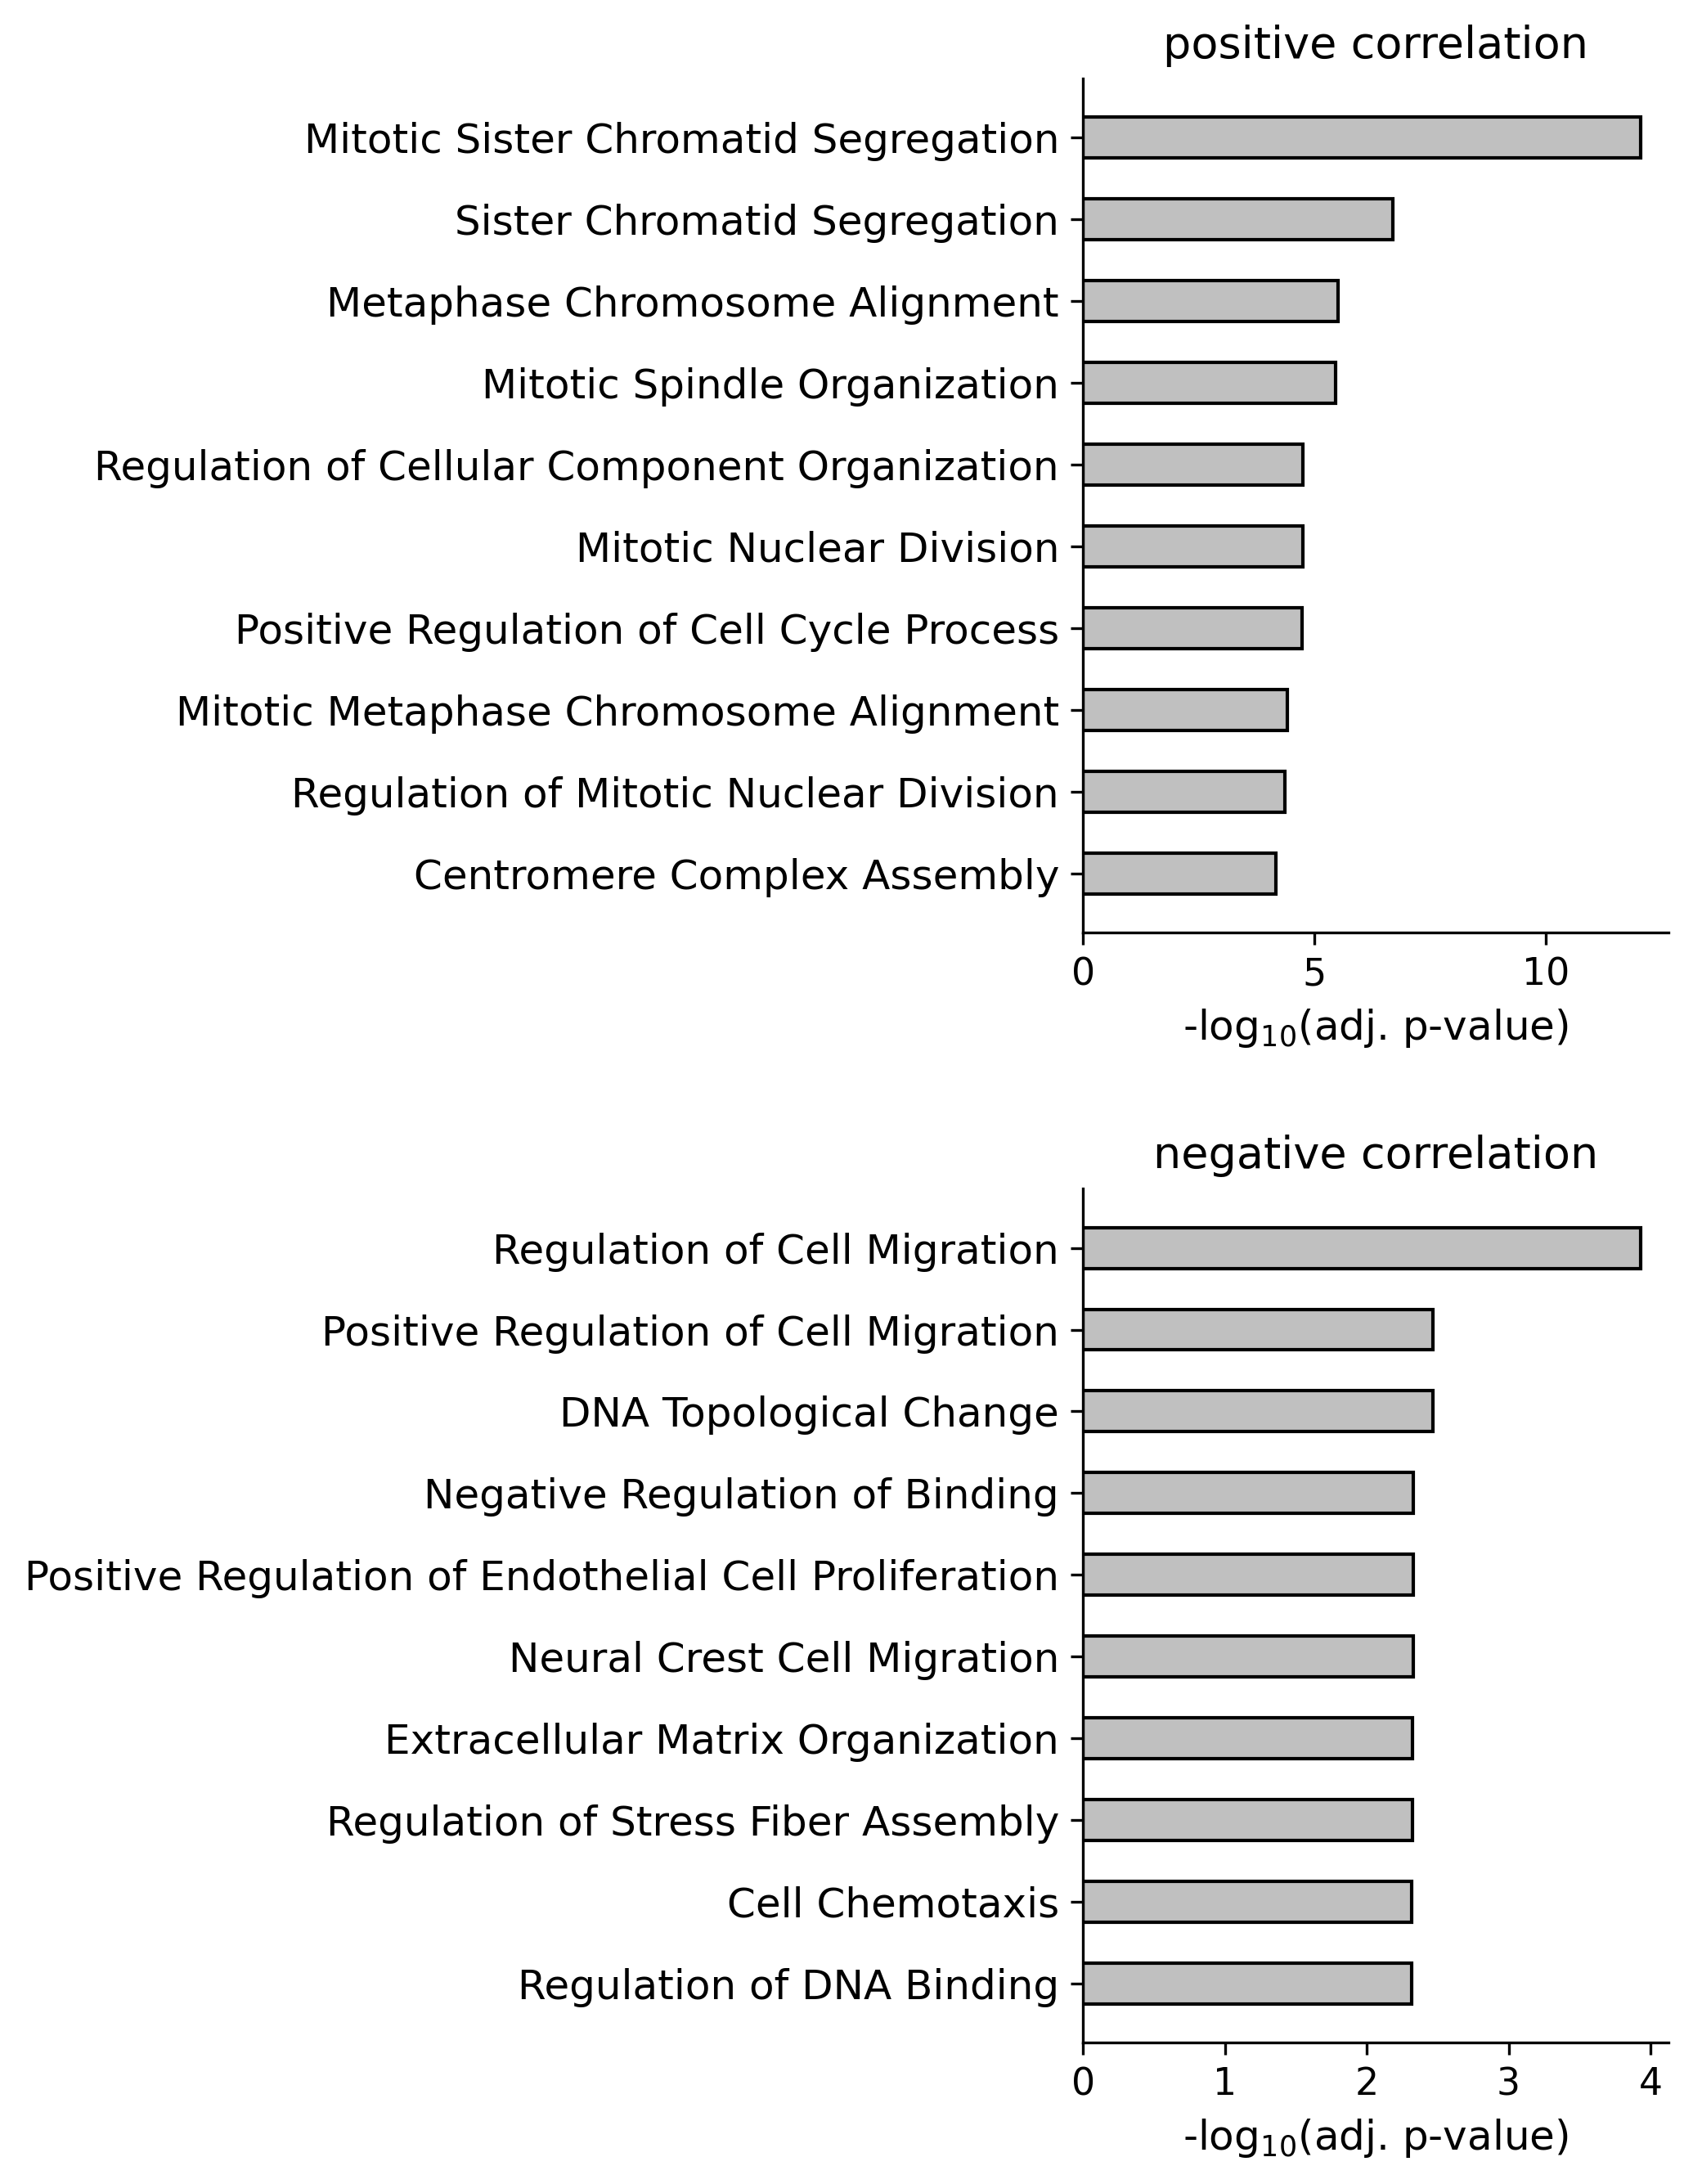

In [80]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 9 #15, 4
fig, axes = plt.subplots(2, 1)
axes = axes.flatten()

n_terms = 10

groups = ['positive correlation', 'negative correlation']

for i, group in enumerate(groups):
    
    if group == 'positive correlation':
        tmp = edf_pos.copy()
    else:
        tmp = edf_neg.copy()
        
    top_terms = tmp[['path_name', 'adj_p_val', 'overlapping_genes']].head(n_terms).copy()

    # Remove IDs in parentheses from path names
    top_terms['path_name'] = top_terms['path_name'].apply(lambda x: re.sub(r"\s*\(.*\)", "", x))
    top_terms['neglog10_p'] = -np.log10(top_terms['adj_p_val'])

    colors = ["silver" if p <= 0.05 else "lemonchiffon" for p in top_terms['adj_p_val']]

    ax = axes[i]
    ax.barh(
        top_terms['path_name'][::-1],
        top_terms['neglog10_p'][::-1],
        color=colors[::-1],
        height=0.5,
        edgecolor='k',
        linewidth=1,
    )

    ax.set_title(f"{group}", fontsize=13)
    ax.set_xlabel("-log$_{10}$(adj. p-value)", fontsize=12)
    ax.set_ylabel("")  
    ax.tick_params(axis='x', labelsize=11)
    ax.tick_params(axis='y', labelsize=12)

sns.despine()
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

In [ ]:
groups = ['C1','C2', 'C3', 'P1', 'P2', 'P3', 'M1', 'M2', 'M3', 'H1', 'H2', 'H3']

n_genes = 300
n_terms = 10
database = "GO_Biological_Process_2025"

direction = 'up'
sort_col = 'scores'

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 25, 15
fig, axes = plt.subplots(4, 3)
axes = axes.flatten()

for i, cond in enumerate(groups):
    if direction == 'up':
        tmp = sig[sig['logfoldchanges'] > 0]
        tmp = tmp[tmp['group'] == cond].sort_values(by=sort_col, ascending=False)
        
    elif direction == 'down':
        tmp = sig[sig['logfoldchanges'] < 0]
        tmp = tmp[tmp['group'] == cond].sort_values(by=sort_col, ascending=True)
    
    # tmp = tmp[tmp['group'] == cond].sort_values(by='logfoldchanges', ascending=False)
    gene_list = tmp['names'].unique()[:n_genes]

    enr = gget.enrichr(gene_list, database, save=False)

    top_terms = enr[['path_name', 'adj_p_val']].head(n_terms).copy()
    # Remove IDs in parentheses from path names
    top_terms['path_name'] = top_terms['path_name'].apply(lambda x: re.sub(r"\s*\(.*\)", "", x))
    top_terms['neglog10_p'] = -np.log10(top_terms['adj_p_val'])

    colors = ["darkolivegreen" if p <= 0.05 else "lemonchiffon" for p in top_terms['adj_p_val']]
    
    ax = axes[i]
    ax.barh(
        top_terms['path_name'][::-1],
        top_terms['neglog10_p'][::-1],
        color=colors[::-1],
        height=0.5,
        edgecolor='k',
        linewidth=0.75,
    )
    
    ax.set_title(f"Cluster {cond}", fontsize=13)
    ax.set_xlabel("-log10(adj. p-value)")
    ax.set_ylabel("")  
    ax.tick_params(axis='y', labelsize=11)

sns.despine()
plt.tight_layout()
plt.show()

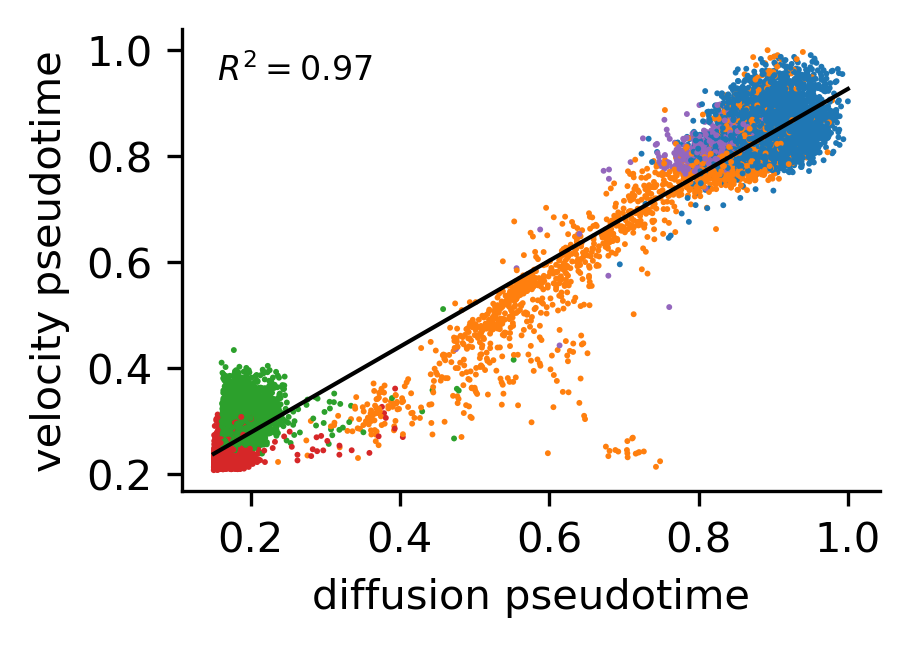

In [22]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2

sns.scatterplot(
    data=adata.obs,
    x='mean_pseudotime',
    y='mean_velocity_pseudotime',
    hue='cluster_str',
    edgecolor='none',
    s=2,
    legend=False,
    linewidth=0
)

# Fit linear model
x = adata.obs['mean_pseudotime']
y = adata.obs['mean_velocity_pseudotime']
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot regression line
x_vals = np.linspace(x.min(), x.max(), 100)
plt.plot(x_vals, intercept + slope * x_vals, color='black', linewidth=1)

# Annotate R²
plt.text(0.05, 0.95, f"$R^2 = {r_value**2:.2f}$", transform=plt.gca().transAxes,
         ha='left', va='top', fontsize=8,
         bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))


# Label axes
plt.xlabel("diffusion pseudotime")
plt.ylabel("velocity pseudotime")

# Remove top and right spines for cleaner visualization
sns.despine()

# Write out

In [23]:
outpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/new_processed/new_scvelo.h5ad"

adata.write(outpath)
adata

AnnData object with n_obs × n_vars = 15317 × 23434
    obs: 'batch', 'barcoded_phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'dpt_pseudotime', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'G1_pseudotime', 'G1_order', 'G2M_pseudotime', 'G2M_order', 'mean_pseudotime', 'mean_order', 'velocyto_cell_id', 'cell_id', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'velocity_pseudotime', 'G1_velocity_pseudotime', 'G2M_velocity_pseudotime', 'mean_velocity_pseudotime'
    var: 'gene_id', 'gene_type', 